## Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Откроем файл с данными и изучим общую информацию. 

*Импортирование нужных библиотек*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from pymystem3 import Mystem

Изучение файла с данными

In [2]:
bank_data = pd.read_csv('/datasets/data.csv')
bank_data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


- children — количество детей в семье
- days_employed — трудовой стаж в днях
- dob_days — возраст клиента в годах
- education — образование клиента
- education_id — идентификатор образования
- family_status — семейное положение
- family_status_id — идентификатор семейного положения
- gender — пол клиента
- income_type — тип занятости
- debt — имел ли задолженность по возврату кредитов
- total_income — доход в месяц
- purpose — цель получения кредита

In [3]:
bank_data.shape

(21525, 12)

In [4]:
bank_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 11.3 MB


In [5]:
bank_data.describe().T

,count,mean,std,min,25%,50%,75%,max
children,21525.0,0.538908,1.381587,-1.000000,0.000000,0.000000,1.000000,2.000000e+01
days_employed,19351.0,63046.497661,140827.311974,-18388.949901,-2747.423625,-1203.369529,-291.095954,4.017554e+05
dob_years,21525.0,43.293380,12.574584,0.000000,33.000000,42.000000,53.000000,7.500000e+01
education_id,21525.0,0.817236,0.548138,0.000000,1.000000,1.000000,1.000000,4.000000e+00
family_status_id,21525.0,0.972544,1.420324,0.000000,0.000000,0.000000,1.000000,4.000000e+00
debt,21525.0,0.080883,0.272661,0.000000,0.000000,0.000000,0.000000,1.000000e+00
total_income,19351.0,167422.302208,102971.566448,20667.263793,103053.152913,145017.937533,203435.067663,2.265604e+06


### Вывод

В данной таблице содержатся 21525 объектов и 12 характеристик.
Данные содержат пропуски (days_employed, total_income), неправильные значения (days_employed, children), значения разного регистра в пределах одного и того же столбца (education), неупорядоченные данные (purpose). Помимо прочего, типы данных неоптимизированы под существующие значения.

### Предобработка данных

### Обработка пропусков

*В таблице есть 2 характеристики с пропущенными значениями - days_employed и total_income. Для того, чтобы понять, чем нужно заполнить пропуски, посмотрим на распределение данных*

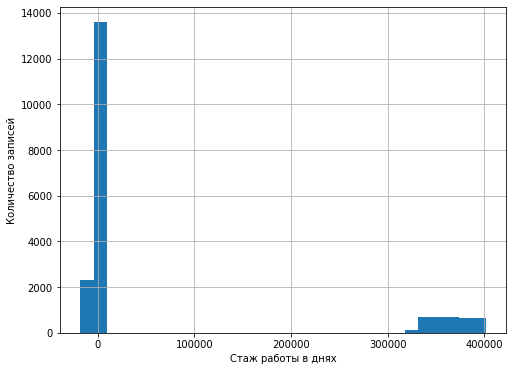

In [6]:
bank_data['days_employed'].hist(bins=30, figsize=(8,6))
plt.xlabel('Стаж работы в днях')
plt.ylabel('Количество записей')
plt.show()

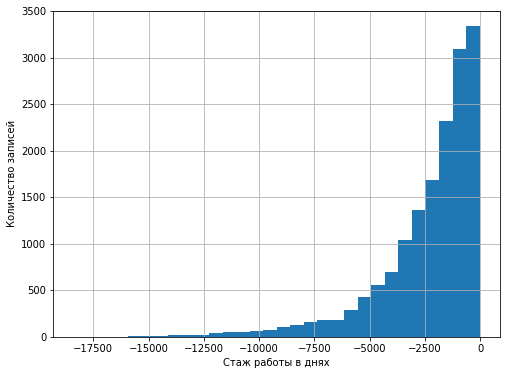

In [7]:
bank_data[bank_data['days_employed'] < 0]['days_employed'].hist(bins=30, figsize=(8,6))
plt.xlabel('Стаж работы в днях')
plt.ylabel('Количество записей')
plt.show()

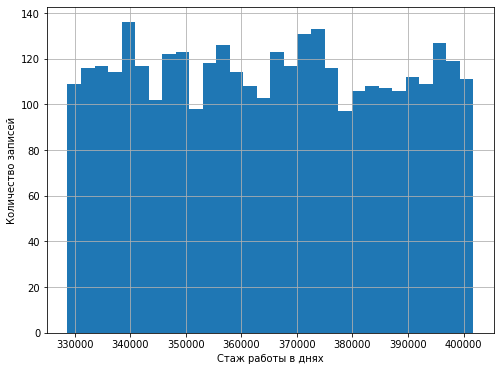

In [8]:
bank_data[bank_data['days_employed'] > 0]['days_employed'].hist(bins=30, figsize=(8,6))
plt.xlabel('Стаж работы в днях')
plt.ylabel('Количество записей')
plt.show()

Как видно из вышеприведенных гистограм, часть значений лежит ниже 0, чего быть не может (стаж работы всегда >= 0). Помимо этого, значения, лежащие выше нуля, явно аномальны (стаж работы исчисляется годами или десятками лет, а здесь мы видим значения в диапазоне от 900 до 1100 лет). Как известно, люди столько не живут. На основании этого необходимо сделать отрицательные значени положительными и проверить, сколько % от всего датасета занимают аномалии.

In [9]:
bank_data['days_employed'] = bank_data['days_employed'].apply(abs) # перевод отрицательных значений в положительные
abnormal_days_employed = len(bank_data[bank_data['days_employed'] > 20000]) / len(bank_data)
print('Процент аномальных данных в столбце days_employed: {:.1%}'.format(abnormal_days_employed))

Процент аномальных данных в столбце days_employed: 16.0%


Такой процент аномальных значений слишком велик, чтобы удалить объекты их содержащие. Поэтому, скорее всего дело в неправильной выгрузке. Логичнее всего присвоить аномалиям новые значения, где значение равно среднему среди неаномальных для человека такого же возраста (стаж работы сильно коррелирует с возрастом).

In [10]:
def format_days_employed(age):
    bank_data.loc[(bank_data['days_employed'] > 20000) & (bank_data['dob_years'] == age), 'days_employed'] = bank_data[(bank_data['days_employed'] < 20000) & (bank_data['dob_years'] == age)]['days_employed'].mean()

In [11]:
bank_data['dob_years'].apply(format_days_employed)

0        None
1        None
2        None
3        None
4        None
         ... 
21520    None
21521    None
21522    None
21523    None
21524    None
Name: dob_years, Length: 21525, dtype: object

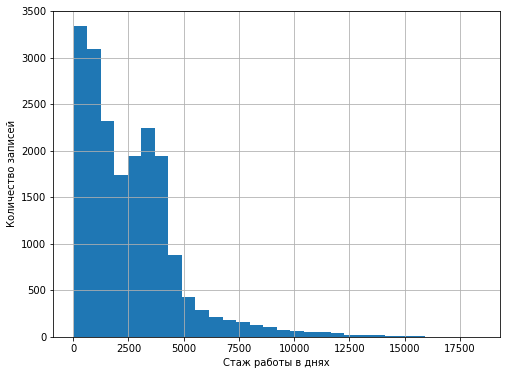

In [12]:
bank_data['days_employed'].hist(bins=30, figsize=(8,6))
plt.xlabel('Стаж работы в днях')
plt.ylabel('Количество записей')
plt.show()

In [13]:
missed_days_employed = bank_data['days_employed'].isnull().sum() / len(bank_data)
print('Пропущенных значений в столбце days_employed: {:.1%}'.format(missed_days_employed))

Пропущенных значений в столбце days_employed: 10.1%


Поскольку в данных присутствует много аномалий, а рабочий стаж зависит в первую очередь от возраста, то заменять аномалии будем значениями усредненным стажем работы людей такого же возраста без учета аномальных значений. Это реализовано в функции ниже. Сами пропущенные значения могли возникнуть в результате технической ошибки.

In [14]:
def fill_days_employed(age):
    bank_data.loc[(bank_data['days_employed'].isna()) & (bank_data['dob_years'] == age), 'days_employed'] = bank_data[bank_data['dob_years'] == age]['days_employed'].mean()
    if bank_data['days_employed'].isnull().sum() == 0:
        return

In [15]:
bank_data['dob_years'].apply(fill_days_employed)

0        None
1        None
2        None
3        None
4        None
         ... 
21520    None
21521    None
21522    None
21523    None
21524    None
Name: dob_years, Length: 21525, dtype: object

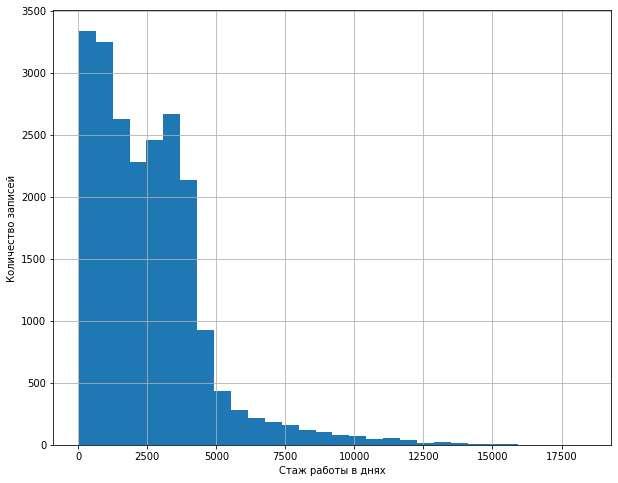

In [16]:
bank_data['days_employed'].hist(bins=30, figsize=(10,8))
plt.xlabel('Стаж работы в днях')
plt.ylabel('Количество записей')
plt.show()

Проверим столбец days_employed на наличие пустых значений.

In [17]:
bank_data['days_employed'].isnull().sum()

0

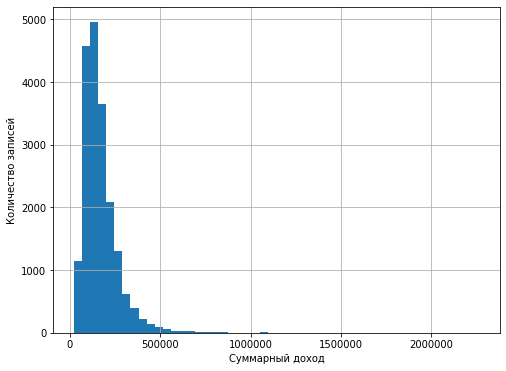

In [18]:
bank_data['total_income'].hist(bins=50, figsize=(8,6))
plt.xlabel('Суммарный доход')
plt.ylabel('Количество записей')
plt.show()

In [19]:
missed_total_income = bank_data['total_income'].isnull().sum() / len(bank_data)
print('Пропущенных значений в столбце total_income: {:.1%}'.format(missed_total_income))

Пропущенных значений в столбце total_income: 10.1%


В столбце total_income также наблюдается тяжелый хвост. Заменим отсутствующие поля total_income усредненными значениями дохода людей такого же возраста.

In [20]:
def fill_total_income(age):
    bank_data.loc[(bank_data['total_income'].isna()) & (bank_data['dob_years'] == age), 'total_income'] = bank_data[bank_data['dob_years'] == age]['total_income'].mean()

In [21]:
bank_data['dob_years'].apply(fill_total_income)

0        None
1        None
2        None
3        None
4        None
         ... 
21520    None
21521    None
21522    None
21523    None
21524    None
Name: dob_years, Length: 21525, dtype: object

Проверим столбец days_employed на наличие пустых значений.

In [22]:
bank_data['total_income'].isnull().sum()

0

In [23]:
bank_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       21525 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 11.3 MB


### Вывод

Хоть столбцов с пропущенными значениями было всего 2, в каждом из них находилось по 10% пропущенных значений относительно размера всей характеристики. Пропущенные значения были заполнены, а аномалии устранены.

### Замена типа данных

*В этом подразделе хочется оптимизировать таблицу данных, потому что многие колонки не соответствуют своим оптимальным типам данных*

In [24]:
bank_data = bank_data.astype({'children': np.int8,
                              'days_employed': np.int32,
                              'dob_years': np.uint8,
                              'education_id': np.uint8,
                              'family_status_id': np.uint8,
                              'debt': np.uint8,
                              'total_income': np.uint32})

int8 - Целые числа в диапазоне от -128 по 127 (числа размером 1 байт)

uint8 - Целые числа в диапазоне от 0 по 255 (числа размером 1 байт)

int32 - Целые числа в диапазоне от -2147483648 по 2147483647 (числа размером 4 байта)

days_employed и total_income были изменены с float на int и uint соответственно

In [25]:
bank_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int8
days_employed       21525 non-null int32
dob_years           21525 non-null uint8
education           21525 non-null object
education_id        21525 non-null uint8
family_status       21525 non-null object
family_status_id    21525 non-null uint8
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null uint8
total_income        21525 non-null uint32
purpose             21525 non-null object
dtypes: int32(1), int8(1), object(5), uint32(1), uint8(4)
memory usage: 10.4 MB


### Вывод

В результате замены типов данных использование памяти сократилось почти на 10%. Также были заменены типы данных в столбцах days_employed и total_income в результате чего с ними станет проще работать.

### Обработка дубликатов

In [26]:
bank_data.duplicated().sum()

54

Удалим дубликаты, ресетнув индексы датафрейма.

In [27]:
bank_data = bank_data.drop_duplicates().reset_index(drop=True)

### Вывод

Дубликатов немного - всего 54 записи. Возможно, так получилось из-за того, что столбцы education и purpose имеют слишклм много уникальных значений и в будущем, при категоризации этих переменных, дубликатов станет больше.

### Лемматизация

*Для начала нужно выяснить, какие столбцы нуждаются в лемматизации. Для этого выведем списки уникальных значений всех столбцов, имеющих тип данных object.*

In [28]:
education_unique = bank_data['education'].unique()
family_status_unique = bank_data['family_status'].unique()
gender_unique = bank_data['gender'].unique()
purpose_unique = bank_data['purpose'].unique()
print(f'{education_unique} \n\n {family_status_unique} \n\n {gender_unique} \n\n {purpose_unique} \n\n')
print(f'Уникальных значений в столбце purpose: {len(purpose_unique)}')

['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'Ученая степень' 'УЧЕНАЯ СТЕПЕНЬ'
 'ученая степень'] 

 ['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'Не женат / не замужем'] 

 ['F' 'M' 'XNA'] 

 ['покупка жилья' 'приобретение автомобиля' 'дополнительное образование'
 'сыграть свадьбу' 'операции с жильем' 'образование'
 'на проведение свадьбы' 'покупка жилья для семьи' 'покупка недвижимости'
 'покупка коммерческой недвижимости' 'покупка жилой недвижимости'
 'строительство собственной недвижимости' 'недвижимость'
 'строительство недвижимости' 'на покупку подержанного автомобиля'
 'на покупку своего автомобиля' 'операции с коммерческой недвижимостью'
 'строительство жилой недвижимости' 'жилье'
 'операции со своей недвижимостью' 'автомобили' 'заняться образованием'
 'сделка с подержанным автомобилем' 'получение образования' 'автомобиль'
 'свадьба' 'получ

Отсюда видно, что в лемматизации нуждается столбец purpose. Но перед слемматизацией стоит обработать значения в столбце education, затем проверить датафрейм на наличие дубликатов и удалить их в случае если они там есть.

In [29]:
bank_data['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

Перевод всех значений столбца education в нижний регистр.

In [30]:
bank_data['education'] = bank_data['education'].str.lower()
bank_data['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

Теперь проверим датасет на наличие дубликатов.

In [31]:
bank_data.duplicated().sum()

17

In [32]:
bank_data = bank_data.drop_duplicates().reset_index(drop=True)

Вернемся к лемматизации. Выведем словарь, где ключ - слово из purpose_unique, а ключ - количество повторений этого слова. Отсортируем словарь по значениям.

In [33]:
mystem = Mystem()
lemmas = mystem.lemmatize(' '.join(purpose_unique))
sorted_lemmas = sorted(Counter(lemmas).items(), key=lambda x: x[1], reverse=True)
sorted_lemmas

[(' ', 96),
 ('покупка', 10),
 ('недвижимость', 10),
 ('автомобиль', 9),
 ('образование', 9),
 ('жилье', 7),
 ('с', 5),
 ('операция', 4),
 ('на', 4),
 ('свой', 4),
 ('свадьба', 3),
 ('строительство', 3),
 ('получение', 3),
 ('высокий', 3),
 ('дополнительный', 2),
 ('для', 2),
 ('коммерческий', 2),
 ('жилой', 2),
 ('подержать', 2),
 ('заниматься', 2),
 ('сделка', 2),
 ('приобретение', 1),
 ('сыграть', 1),
 ('проведение', 1),
 ('семья', 1),
 ('собственный', 1),
 ('со', 1),
 ('профильный', 1),
 ('сдача', 1),
 ('ремонт', 1),
 ('\n', 1)]

На основании самых частоповторяющихся слов и с учетом их значения в контексте предложений было решено классифицировать данные столбца по 4 значениям: недвижимость, автомобиль, образование и свадьба.

In [34]:
def lemmer(row):
    lemma = mystem.lemmatize(row)
    if 'недвижимость' in lemma or 'жилье' in lemma:
        return 'недвижимость'
    elif 'автомобиль' in lemma:
        return 'автомобиль'
    elif 'образование' in lemma:
        return 'образование'
    elif 'свадьба' in lemma:
        return 'свадьба'
    else:
        pass

In [35]:
bank_data['purpose'] = bank_data['purpose'].apply(lemmer)

In [36]:
bank_data['purpose'].unique()

array(['недвижимость', 'автомобиль', 'образование', 'свадьба'],
      dtype=object)

Теперь в столбце purpose 4 уникальных значения. Лемматизация прошла успешно.

In [37]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 12 columns):
children            21454 non-null int8
days_employed       21454 non-null int32
dob_years           21454 non-null uint8
education           21454 non-null object
education_id        21454 non-null uint8
family_status       21454 non-null object
family_status_id    21454 non-null uint8
gender              21454 non-null object
income_type         21454 non-null object
debt                21454 non-null uint8
total_income        21454 non-null uint32
purpose             21454 non-null object
dtypes: int32(1), int8(1), object(5), uint32(1), uint8(4)
memory usage: 1.1+ MB


### Вывод

В результате проведенной лемматизации столбец purpose, содержащий 38 уникальных элементов, теперь состоит из 4 категорий. Теперь работать с ним гораздо легче. Также, в процессе поиска столбца для проведения леммитизации был найден столбец education, содержащий строки с символами разного регистра.

### Категоризация данных

Так как один из вопросов, на который нужно ответить, - зависит ли возврат кредита в срок от наличия детей, то необходимо создать колонку данных, где 1 значит что в семье есть 1 и более детей, а 0 будет означать отсутсвтие детей.

Для начала посмотрим на сами данные.

In [38]:
bank_data['children'].describe()

count    21454.000000
mean         0.539946
std          1.383444
min         -1.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         20.000000
Name: children, dtype: float64

In [39]:
bank_data[bank_data['children'] == -1].shape

(47, 12)

В датасете есть 47 записей, где rоличество детей равно -1. Удалим эти данные.

In [40]:
bank_data = bank_data.drop(bank_data[bank_data['children'] == -1].index).reset_index(drop=True)

In [41]:
abnormal_child_amount = len(bank_data[bank_data['children'] == 20])
max_child_number_except_abnormal = bank_data[bank_data['children'] != 20]['children'].max()
print(f'Количество записей с 20 детьми: {abnormal_child_amount} записей')
print(f'Максимальное количество детей в записях, за исключением 20: {max_child_number_except_abnormal} детей')

Количество записей с 20 детьми: 76 записей
Максимальное количество детей в записях, за исключением 20: 5 детей


Исходя из этого, можно полагать, что записи, в которых количество детей равно 20 - аномальные. Выбросим эти данные.

In [42]:
bank_data = bank_data.drop(bank_data[bank_data['children'] == 20].index).reset_index(drop=True)

In [43]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21331 entries, 0 to 21330
Data columns (total 12 columns):
children            21331 non-null int8
days_employed       21331 non-null int32
dob_years           21331 non-null uint8
education           21331 non-null object
education_id        21331 non-null uint8
family_status       21331 non-null object
family_status_id    21331 non-null uint8
gender              21331 non-null object
income_type         21331 non-null object
debt                21331 non-null uint8
total_income        21331 non-null uint32
purpose             21331 non-null object
dtypes: int32(1), int8(1), object(5), uint32(1), uint8(4)
memory usage: 1.1+ MB


Создаем новую колонку.

In [44]:
bank_data['has_children'] = bank_data['children'].apply(lambda x: 1 if x >= 1 else 0).astype(np.uint8)

Для ответа на вопрос о том, как коррелирует уровень дохода с возвратом долга, сначала следут категоризировать саму переменную total_income. Для этого можно воспользоваться 33% и 66% процентилями.

In [45]:
total_income_metrics = bank_data['total_income'].describe(percentiles=[.33, .66]).astype(np.uint32)
total_income_metrics

count      21331
mean      167441
std        98016
min        20667
33%       122112
50%       152852
66%       177110
max      2265604
Name: total_income, dtype: uint32

Создаем 2 переменные, содержащие значения 33% и 66% процентилей.

In [46]:
procentile_33 = total_income_metrics[4]
procentile_66 = total_income_metrics[6]

Далее создаем 3 новых столбца в датафрейме (низкий доход, средний доход и высокий доход).

In [48]:
def income_to_categories(row):
    if row <= procentile_33:
        return 'low_income'
    elif procentile_33 < row < procentile_66:
        return 'medium_income'
    else:
        return 'high_income'

In [49]:
bank_data['total_income'] = bank_data['total_income'].apply(income_to_categories)

In [50]:
bank_data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,has_children
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,high_income,недвижимость,1
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,low_income,автомобиль,1
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,medium_income,недвижимость,0
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,high_income,образование,1
4,0,3280,53,среднее,1,гражданский брак,1,F,пенсионер,0,medium_income,свадьба,0


### Вывод

Все необходимые переменные для ответа на вопрос были категоризированы.

### Ответы на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

Для этого построим график корреляции столбцов children (количество детей) и has_children (есть дети или нет)

In [51]:
children_pivot = bank_data.pivot_table(index='children', values='debt', aggfunc=['count','sum','mean'])
children_pivot

,count,sum,mean
,debt,debt,debt
children,,,
0,14091,1063.0,0.075438
1,4808,444.0,0.092346
2,2052,194.0,0.094542
3,330,27.0,0.081818
4,41,4.0,0.097561
5,9,0.0,0.000000


In [52]:
has_children_pivot = bank_data.pivot_table(index='has_children', values='debt', aggfunc=['count','sum','mean'])
has_children_pivot

,count,sum,mean
,debt,debt,debt
has_children,,,
0,14091,1063.0,0.075438
1,7240,669.0,0.092403


### Вывод

Как видно из первой сводной таблицы существует следующая зависимость: чем больше детей в семье - тем больше вероятность того, что заемщик будет иметь задолженность (за исключением семей из 3 детей, однако, возможно что это связано с неполнотой данных). Вторая сводная таблица подтверждает результаты, полученые ранее - заемщики без детей возвращают долг чаще, чем заемщики с детьми.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [53]:
family_pivot = bank_data.pivot_table(index='family_status', values='debt', aggfunc=['count','sum','mean'])
family_pivot

,count,sum,mean
,debt,debt,debt
family_status,,,
Не женат / не замужем,2796,273.0,0.097639
в разводе,1189,84.0,0.070648
вдовец / вдова,951,63.0,0.066246
гражданский брак,4134,385.0,0.093130
женат / замужем,12261,927.0,0.075606


### Вывод

Долг чаще выплачивают овдовевшие и люди, находящиеся в разводе. Хуже всего те, кто живет в гражданском браке или же с зарегистрированным браком.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [55]:
income_pivot = bank_data.pivot_table(index='total_income',values='debt', aggfunc=['count','sum','mean'])
income_pivot

,count,sum,mean
,debt,debt,debt
total_income,,,
high_income,7278,556.0,0.076395
low_income,7039,578.0,0.082114
medium_income,7014,598.0,0.085258


### Вывод

Люди со средним доходом чаще всего не возвращают долг, а люди с высоким, как и ожидалось, возвращают его чаще остальных.

- Как разные цели кредита влияют на его возврат в срок?

In [56]:
purpose_pivot = bank_data.pivot_table(index='purpose', values='debt', aggfunc=['count','sum','mean'])
purpose_pivot

,count,sum,mean
,debt,debt,debt
purpose,,,
автомобиль,4279,400.0,0.093480
недвижимость,10751,780.0,0.072551
образование,3988,369.0,0.092528
свадьба,2313,183.0,0.079118


### Вывод

Самый большой коэффициент возврата у людей, которые берут займ на недвижимость. Это может быть связано с тем, что частично недвижимость покупается для инвестиционных целей. Самые маленькие коэффициенты возврата займа у тех, кто берет деньги на автомобиль и образование. Автомобиль, как правило, является противоположностью недвижимости, то есть пассивом. Это часто неоправданные траты (сама покупка автомобиля и его обслуживание). Говоря про образование, то у тех, кто берет на него займ, просто нет денег - это обычно студенты с низким уровнем дохода.

### Общий вывод

Данный датасет был изучен, заполнены пропущенные значения, удалены дубликаты, данные приведены к оптимальным и удобным типам, проведена категоризация данных. Были найдены зависимости между наличием детей, их количеством в семье, семейным статусом, целью кредита и возвратом займа. Портрет самой платежеспособной аудитории: человек в разводе и без детей, с высоким доходом, который берет деньги на недвижимость или на свадьбу. Самые неплатежеспособные оказились те, кто не замужем или не женат, имеет много детей (чем их больше - тем хуже платежеспособность), с низким или средним доходом, берущие займ под автомобиль.